In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Satıcılar

🎯 Amacımız, diğerlerine göre tekrarlı olarak düşük performans gösteren satıcıları bulmak ve nedenini anlamaktır.  
Bu, Olist'in gelecekte kâr marjını artırmaya yönelik önerilerimizi şekillendirmemize yardımcı olacaktır.

## 1 - `olist/seller.py`  

`order.py` ile benzer bir süreçte, size `olist/seller.py` modülünü sunduk; içinde `Seller` sınıfı ve `Seller().get_training_data` yöntemi bulunuyor. Bu yöntem aşağıdaki özellikleri içeren bir DataFrame döndürür:

| feature_name | type | açıklama |
| --- | --- | --- |
| `seller_id` | str | satıcının benzersiz kimliği (UNIQUE) |
| `seller_city` | str | satıcının bulunduğu şehir |
| `seller_state` | str | satıcının bulunduğu eyalet |
| `delay_to_carrier` | float | sipariş, `shipping_limit_date`'den önce teslim edildiyse 0 döner; aksi takdirde gecikme süresini verir |
| `wait_time` | float | satıcı başına ortalama teslimat süresi (bekleme süresi) |
| `date_first_sale` | datetime | Olist üzerinde yapılan ilk satışın tarihi |
| `date_last_sale` | datetime | Olist üzerindeki son satışın tarihi |
| `months_on_olist` | float | Olist'te geçirilen yaklaşık ay sayısı |
| `share_of_five_stars` | float | satıcının yer aldığı siparişlerdeki beş yıldız değerlendirmelerinin oranı |
| `share_of_one_stars` | float | satıcının yer aldığı siparişlerdeki bir yıldız değerlendirmelerinin oranı |
| `review_score` | float | satıcının yer aldığı siparişler için ortalama değerlendirme puanı |
| `n_orders` | int | satıcının yer aldığı benzersiz sipariş sayısı |
| `quantity` | int | bu satıcı tarafından satılan toplam ürün adedi |
| `quantity_per_order` | float | bu satıcı için sipariş başına ortalama ürün sayısı |
| `sales` | float | bu satıcı ile ilişkili toplam satış tutarı (kargo hariç), BRL cinsinden |

❓ **Aşağıya yeni sınıfınızı import edin ve eğitim veri çerçevenizi inceleyin!** Kodları incelemek için zaman ayırın ve sizin için tam olarak nelerin hesaplandığını anlayın.

In [1]:
from olist.seller import Seller

# Seller sınıfından bir örnek oluşturalım
seller_factory = Seller()

# Eğitim veri setini çekelim
sellers = seller_factory.get_training_data()

# İlk 5 satırı inceleyelim
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


🤔 Her satıcı için henüz hesaplanması gereken bir şey kaldı:
- Aşırı yüksek değerlendirmelerin oranı (`share_of_five_stars`) ve aşırı düşük değerlendirmelerin oranı (`share_of_one_stars`)
- (ortalama) `review_score`

😱 Düşük puanlı her sipariş Olist'in itibarına olumsuz etki yapar; bu etki `cost_of_review` ile modellenir.

Bu, daha sonra her satıcı için toplam `cost_of_review`'u hesaplamamıza yardımcı olacak!

❓ **Sizin doldurmanız gereken son metod: `get_review_score()`'u implemente edin.**

In [1]:
# 1. Önce hafızayı tazelemek için sınıfı tekrar çağıralım
from olist.seller import Seller
seller_factory = Seller()

# 2. Eğitim verisini yeni metodumuzla çekelim
# Bu tablo artık review_score sütununu İÇERMELİ
sellers = seller_factory.get_training_data()

# 3. Kontrol: review_score sütunu geldi mi?
print("Sütunlar:", sellers.columns)
sellers.head()

Sütunlar: Index(['seller_id', 'seller_city', 'seller_state', 'n_orders', 'quantity',
       'sales', 'wait_time', 'delay_to_carrier', 'date_first_sale',
       'date_last_sale', 'months_on_olist', 'quantity_per_order',
       'review_score', 'share_of_one_stars', 'share_of_five_stars'],
      dtype='object')


,seller_id,seller_city,seller_state,n_orders,quantity,sales,wait_time,delay_to_carrier,date_first_sale,date_last_sale,months_on_olist,quantity_per_order,review_score,share_of_one_stars,share_of_five_stars
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,3,3,218.70,13.018588,1.514329,2017-05-11 16:25:11,2017-09-05 12:50:19,4.0,1.000000,3.00,0.333333,0.333333
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,39,40,11413.17,9.065716,0.155190,2017-04-05 02:10:34,2018-06-14 20:15:21,15.0,1.025641,4.55,0.050000,0.725000
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,1,1,158.00,4.042292,0.000000,2018-08-03 12:44:49,2018-08-03 12:44:49,1.0,1.000000,5.00,0.000000,1.000000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,1,1,79.99,5.667187,0.000000,2018-08-09 00:44:08,2018-08-09 00:44:08,1.0,1.000000,5.00,0.000000,1.000000
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,1,1,167.99,35.314861,3.353727,2017-11-24 12:15:25,2017-11-24 12:15:25,1.0,1.000000,1.00,1.000000,0.000000


🧪 Kodunuzu aşağıda test edin

In [1]:
from olist.seller import Seller
from nbresult import ChallengeResult

# Veriyi çekelim (Yeni kodunla 2967 satır gelecek)
tmp = Seller().get_training_data()

# Testi yapalım
result = ChallengeResult('seller',
    shape = tmp.shape,
    median = tmp.review_score.median(),
    columns = tmp.columns
)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/macos/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/macos/Desktop/data-sellers/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 3 items

test_seller.py::TestSeller::test_column_names PASSED                     [ 33%]
test_seller.py::TestSeller::test_median_review_score PASSED              [ 66%]
test_seller.py::TestSeller::test_shape PASSED                            [100%]

============================== 3 passed in 0.81s ===============================


💯 You can commit your code:

git add tests/seller.pickle

git commit -m 'Completed seller step'

git push origin master



💡 **Tam satır sayısını elde edemiyor musunuz?**
<details><summary>Fazladan 3 satır mı var?</summary>
Left veya right join mi yaptınız? Nedenini anlıyoruz; fakat burada sadece değerlendirme alan satıcılarla ilgileniyoruz; bu yüzden inner join kullandık.
</details>
<details><summary>2 satır mı eksik?</summary>
`Orders().get_training_data()`'ı mı kullandınız? Bu geçerli bir seçenek, fakat sadece değerlendirmelerle ilgileniyorsak biraz aşırı olabilir. O method birçok hesaplama yapar ve döndürdüğü sütunların çoğuna ihtiyaç duymuyoruz. İhtiyacımıza daha uygun başka bir `Order` methodu bulun.
</details>

⚠️ `olist` reposundaki `seller.py` dosyasına yaptığınız kod değişikliklerini commit etmeyi unutmayın!

## 2 - Satıcıları İnceleme

### (2.1) Görselleştirmeler

Bu satıcılar hakkında ilk ***`EDA - Keşifsel Veri Analizi`*** ile başlayalım.

👉 `sellers` için özet istatistiklere bakın. Satıcı başına siparişlerin medyanı nedir ❓

In [4]:
# 1. Önce veriyi değişkene atayalım
from olist.seller import Seller
sellers = Seller().get_training_data()

# 2. Tüm sayısal sütunların özet istatistiklerine bakalım
print(sellers.describe())

# 3. Satıcı başına sipariş sayısının (n_orders) medyanını bulalım
median_orders = sellers['n_orders'].median()
print(f"\nSatıcı başına siparişlerin medyanı: {median_orders}")

          n_orders     quantity          sales    wait_time  delay_to_carrier  \
count  2967.000000  2967.000000    2967.000000  2967.000000       2967.000000   
mean     32.964948    37.136839    4453.421682    12.137544          0.567669   
min       1.000000     1.000000       6.500000     1.214178          0.000000   
25%       2.000000     2.000000     219.800000     8.287658          0.000000   
50%       7.000000     8.000000     845.000000    11.115143          0.000000   
75%      22.000000    26.000000    3494.020000    14.227526          0.160471   
max    1819.000000  1996.000000  226987.930000   189.863160         45.434039   
std     105.454672   119.727146   13933.329803     7.068122          2.367880   

                     date_first_sale                 date_last_sale  \
count                           2967                           2967   
mean   2017-10-31 10:26:43.092686336  2018-04-28 15:27:45.545669120   
min              2016-09-19 23:11:33            2016-10-1

👉 Bir sonraki adımda, veri setindeki her sayısal değişkenin dağılımını tek bir büyük görselde çizeceğiz. 

Kod size verildi, hücreyi çalıştırmanız yeterli.

- 👀 Herhangi bir aykırı değer fark ediyor musunuz?
- Sipariş sayısının dağılımı nasıl görünüyor ❓

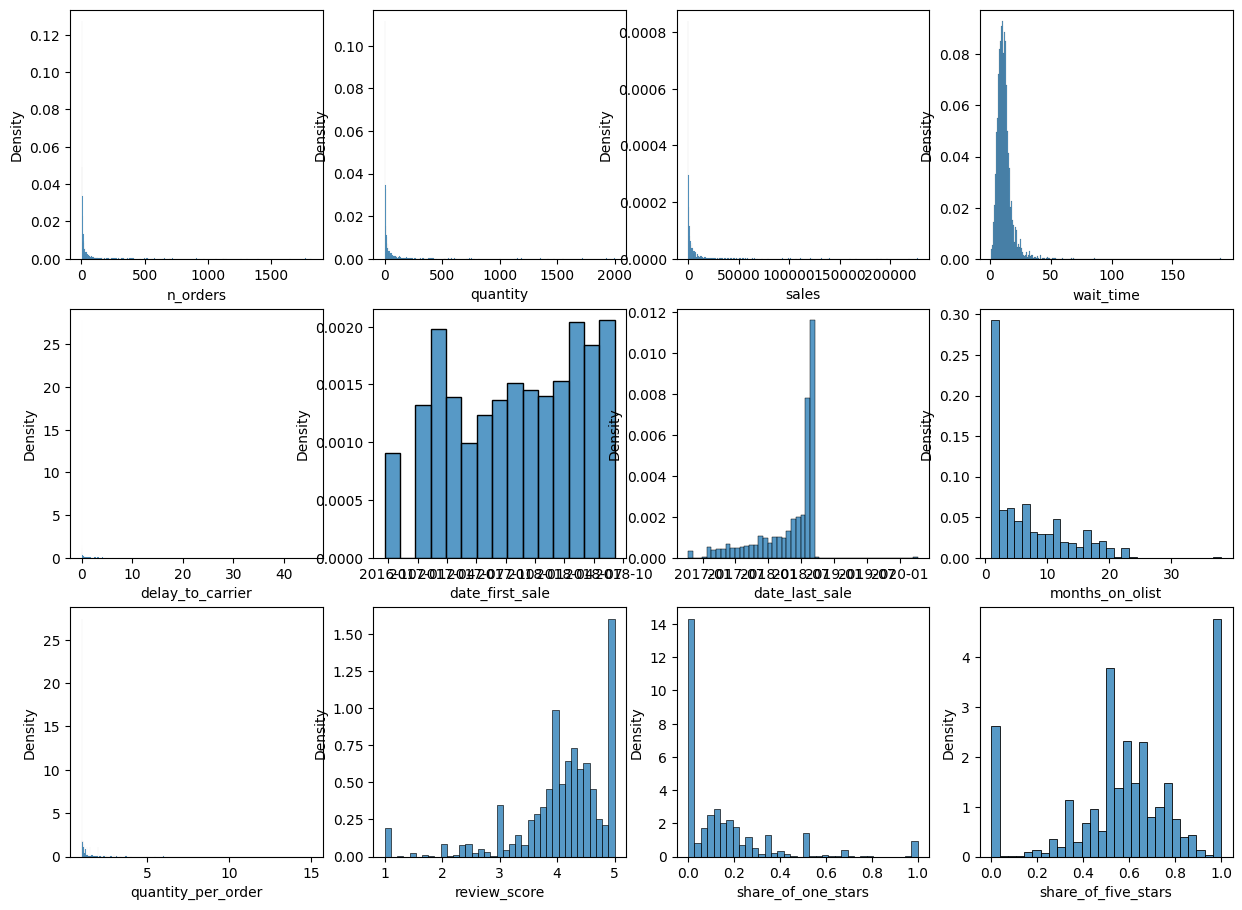

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hocanın verdiği orijinal kod buradan devam etsin
plt.figure(figsize=(15,11))
for (i, col) in enumerate(sellers.describe().columns):
    plt.subplot(3,4,i+1)
    sns.histplot(sellers[col], kde=False, stat='density') # Parametreleri sadeleştirebilirsin

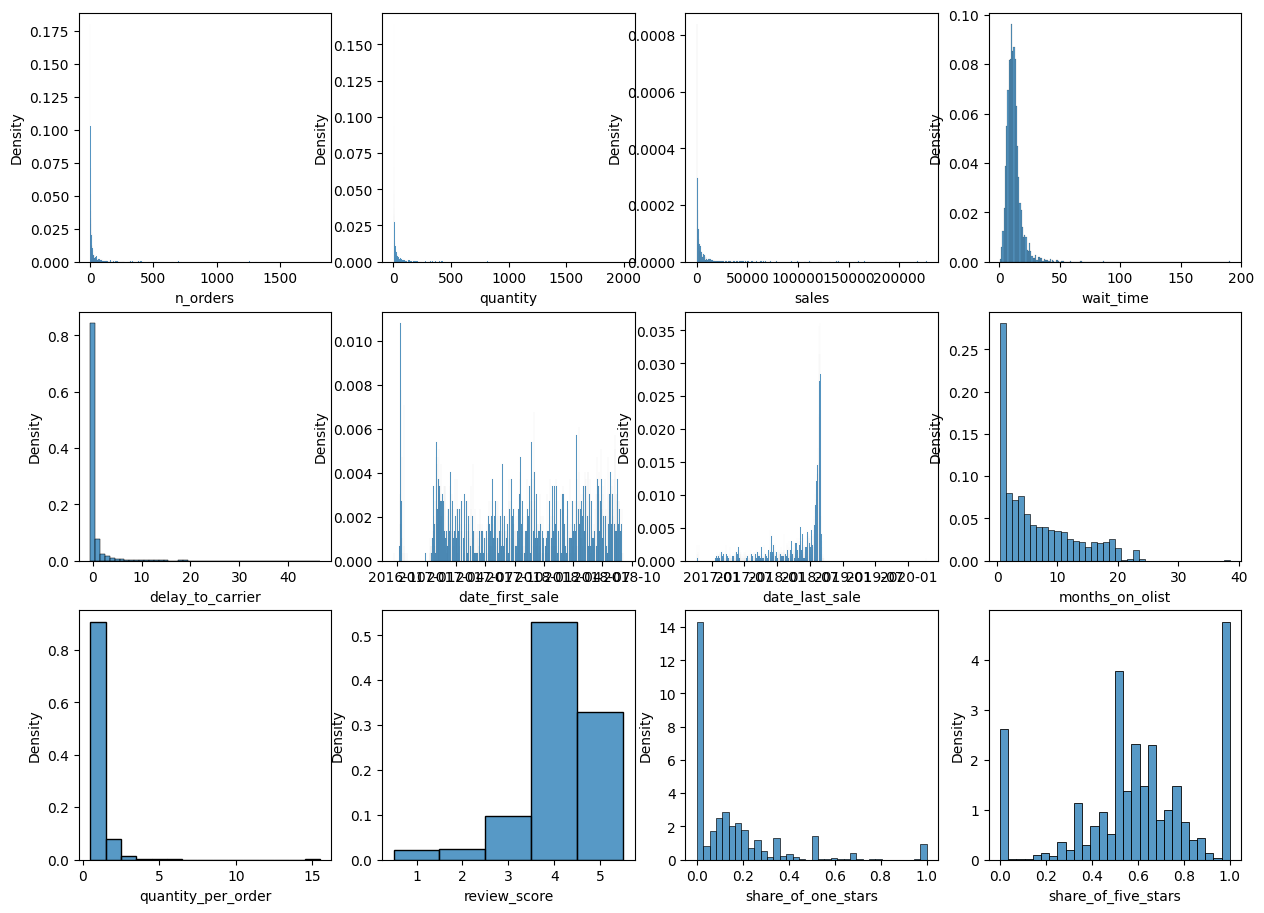

In [7]:
plt.figure(figsize=(15,11))
for (i, col) in enumerate(sellers.describe().columns):#["wait_time", "delay_to_carrier", "avg_review_score", "n_orders", "quantity", "price"]):
    plt.subplot(3,4,i+1)
    sns.histplot(sellers[col], kde=False, stat='density', discrete=[True,None][col in ['share_of_one_stars','share_of_five_stars','sales']]);

💡 Çok düşük değerlendirme puanlarına sahip bir grup satıcının öne çıktığı görünüyor!

📊 Grafiksel olarak inceleyelim:
- `plotly` kullanarak `delay_to_carrier` ile `wait_time` arasındaki ilişkiyi gösteren bir saçılma grafiği (scatterplot) oluşturuyoruz; kabarcık boyutunu satıcının toplam `sales`'i, rengini ise `review_score` belirliyor.

`plotly`'ı daha sonra detaylı göreceğiz; şimdilik aşağıdaki hücreyi çalıştırın.

In [8]:
import plotly.express as px
fig = px.scatter(data_frame = sellers[sellers['review_score'] < 4],
    x="wait_time",
    y="delay_to_carrier",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5
)
fig.show()

En kötü satıcıları bulmak için `x`, `y`, `color` ve `size` değerlerini değiştirmekten çekinmeyin.

### (2.2) `review_score`'u OLS ile modelleme

⚠️ Saçılma grafikleri veriyi görsel olarak analiz etmemizi sağlar, fakat sınırlamaları vardır: deneme-yanılma içerir ve ilişkileri yalnızca niteliksel değerlendiririz.

💡 **Satıcıların `review_score`** değişkenini açıklamak için daha sağlam bir yöntem, `statsmodels` içinde **çok değişkenli (multivariate) OLS** kullanarak çeşitli özelliklerin `review_score` üzerindeki etkisini modellemektir.

İstediğiniz sayısal özellikleri kullanarak bir OLS oluşturalım.

👉 Regresyon katsayılarını karşılaştırabilmek için önce aşağıdaki `standardize` fonksiyonunu kullanarak özelliklerinizi standardize edin.

In [9]:
def standardize(df, features):
    """Standardize specified numerical features in a DataFrame using z-score.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    features : list of str
        List of column names to standardize.

    Returns
    -------
    pandas.DataFrame
        A copy of the original dataframe where the specified features have been
        standardized to zero mean and unit variance. Other columns are left
        unchanged.
    """
    df_standardized = df.copy()
    mu = df[features].mean()
    sigma = df[features].std()
    df_standardized[features] = (df[features] - mu) / sigma
    return df_standardized

In [10]:
# 1. Modelde kullanacağımız sayısal özellikleri seçelim
features = ['delay_to_carrier', 'wait_time', 'n_orders', 'quantity', 'sales']

# 2. Seçtiğimiz özellikleri yukarıda tanımlanan fonksiyonla standardize edelim
sellers_standardized = standardize(sellers, features)

# 3. Statsmodels kullanarak OLS modelini kuralım
import statsmodels.formula.api as smf

# 'review_score' hedef değişkenimiz (y), diğerleri açıklayıcı değişkenlerimiz (X)
formula = "review_score ~ " + " + ".join(features)
model = smf.ols(formula=formula, data=sellers_standardized).fit()

# 4. Model özetini görelim
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     145.1
Date:                Thu, 19 Feb 2026   Prob (F-statistic):          4.87e-138
Time:                        15:15:27   Log-Likelihood:                -3228.0
No. Observations:                2967   AIC:                             6468.
Df Residuals:                    2961   BIC:                             6504.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1015      0.013    310.746      0.000       4.076       4.127
delay_to_carrier    -0.1437      0.015     -9.467      0.000      -0.173      -0.114
wait_time           -0.2617      0.015    -17.242      0.000      -0.292      -0.232
n_orders             0.1498      0.115      1.297      0.195      -0.077       0.376
quantity            -0.1662      0.115     -1.451      0.147      -0.391       0.058
sales                0.0150      0.022      0.680      0.496      -0.028       0.058
==============================================================================
Omnibus:                      863.794   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3041.890
Skew:                          -1.427   Prob(JB):                         0.00
Kurtosis:                       7.058   Cond. No.                         20.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

👉 Sonraki adımda bir OLS modeli oluşturun ve fit edin.

In [11]:
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

❓ En etkili özellikler hangileri?

👉 Sıralanmış katsayılarla bir 📊 `bar_plot` çizin.

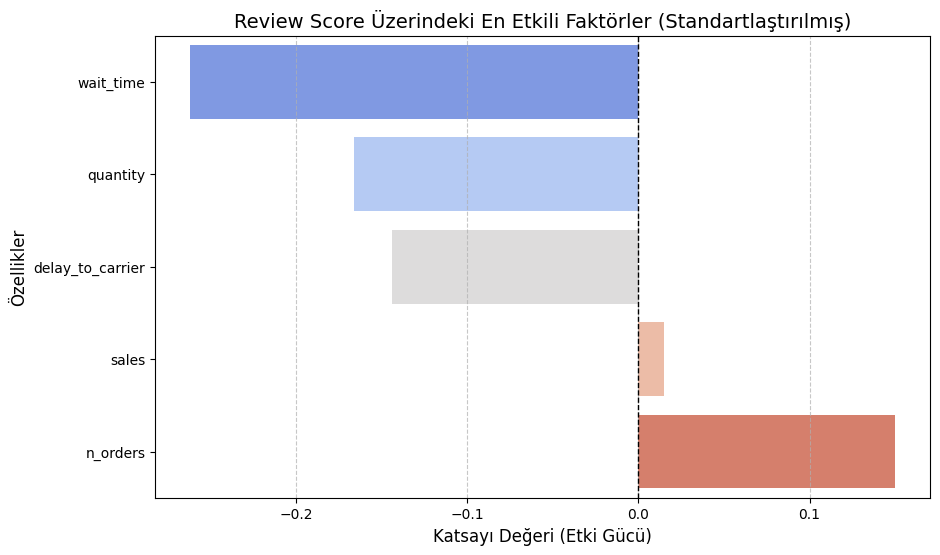

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Katsayıları (Intercept hariç) alıp küçükten büyüğe sıralayalım
params = model.params.drop('Intercept').sort_values()

# 2. Görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x=params.values, y=params.index, hue=params.index, palette='coolwarm', legend=False)

# Grafiği süsleyelim
plt.title('Review Score Üzerindeki En Etkili Faktörler (Standartlaştırılmış)', fontsize=14)
plt.xlabel('Katsayı Değeri (Etki Gücü)', fontsize=12)
plt.ylabel('Özellikler', fontsize=12)
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

👉 Son olarak modelinizin performansını (`R-squared`) ve `residuals`'ı inceleyin

Modelin R-squared (Belirlilik Katsayısı) değeri: 0.1968


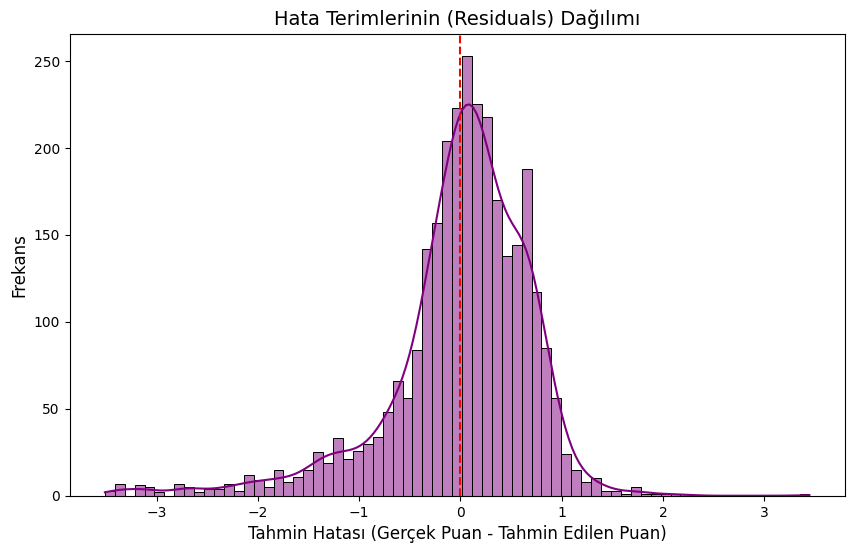

In [13]:
# 1. Modelin açıklayıcılık gücünü (R-squared) yazdıralım
print(f"Modelin R-squared (Belirlilik Katsayısı) değeri: {model.rsquared:.4f}")

# 2. Hata terimlerinin (Residuals) dağılımını görelim
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True, color='purple')

plt.title('Hata Terimlerinin (Residuals) Dağılımı', fontsize=14)
plt.xlabel('Tahmin Hatası (Gerçek Puan - Tahmin Edilen Puan)', fontsize=12)
plt.ylabel('Frekans', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--') # Hataların 0 etrafında toplanmasını bekleriz
plt.show()

👉 Gerçek değerlendirme puanlarını ve modelin tahmin ettiği puanları aynı grafikte göstererek karşılaştırın.

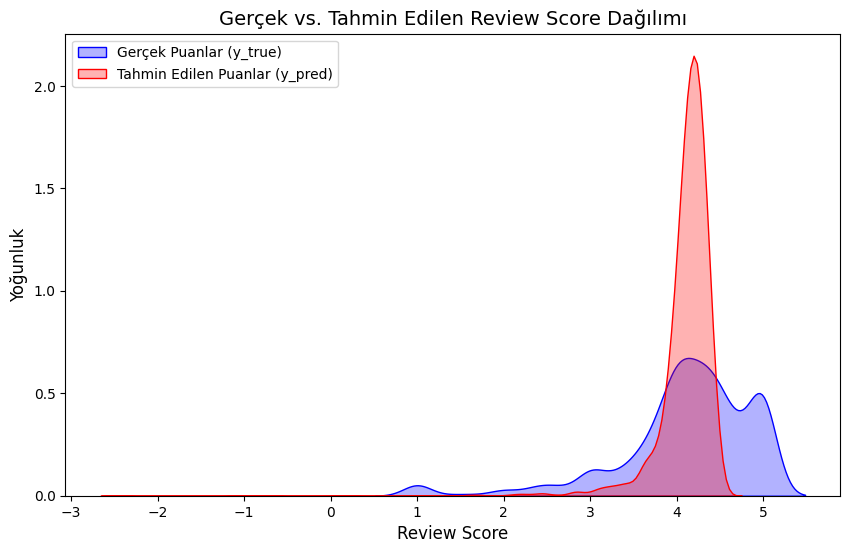

In [14]:
# 1. Modelden tahminleri (y_pred) alalım
y_pred = model.predict(sellers_standardized)
y_true = sellers_standardized['review_score']

# 2. İki dağılımı aynı grafikte karşılaştıralım
plt.figure(figsize=(10, 6))

sns.kdeplot(y_true, label='Gerçek Puanlar (y_true)', fill=True, color='blue', alpha=0.3)
sns.kdeplot(y_pred, label='Tahmin Edilen Puanlar (y_pred)', fill=True, color='red', alpha=0.3)

plt.title('Gerçek vs. Tahmin Edilen Review Score Dağılımı', fontsize=14)
plt.xlabel('Review Score', fontsize=12)
plt.ylabel('Yoğunluk', fontsize=12)
plt.legend()
plt.show()

👉 Artıkları (residuals) görselleştirin

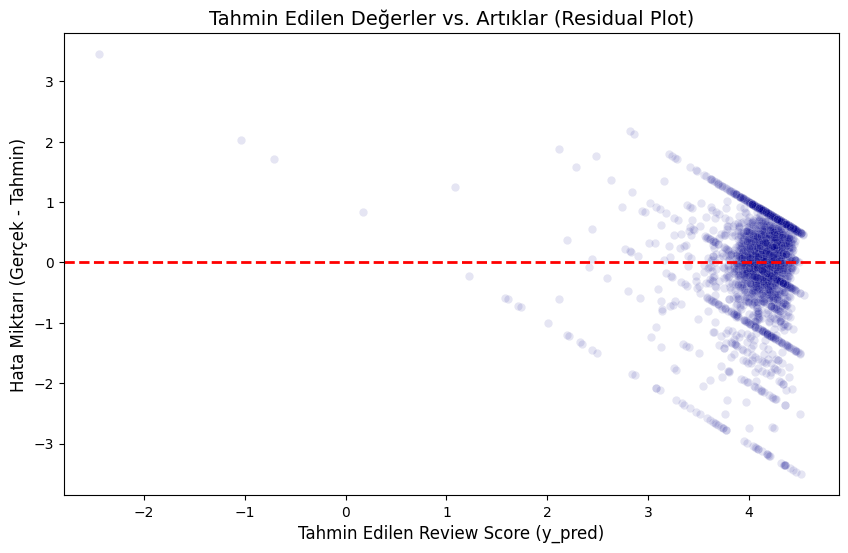

In [15]:
# 1. Artıkları (Hataları) tahmin edilen değerlere göre çizelim
plt.figure(figsize=(10, 6))

# Şeffaflık (alpha) ekliyoruz çünkü binlerce nokta üst üste binecek
sns.scatterplot(x=y_pred, y=model.resid, alpha=0.1, color='darkblue')

plt.title('Tahmin Edilen Değerler vs. Artıklar (Residual Plot)', fontsize=14)
plt.xlabel('Tahmin Edilen Review Score (y_pred)', fontsize=12)
plt.ylabel('Hata Miktarı (Gerçek - Tahmin)', fontsize=12)

# Hataların 0 etrafında dengelenmesini bekleriz
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.show()

### (2.3) Analize `seller_state` bilgisini ekleyin

❓ Henüz `seller_state` bilgisini kullanmadık.  
- Sadece `seller_state`'lere karşı `review_score`'u regresyonla modelleyen yeni bir OLS oluşturun.
- `olist/utils.py` içinde sizin için yazılmış olan `return_significative_coef(model)` fonksiyonunu kullanarak anlamlı (significant) özellikleri analiz edin.
- `review_score` açısından en iyi eyaletler hangileri?

<details>
    <summary>- İpuçları -</summary>
        
⚠️ Dikkat, `seller_state` kategorik bir özelliktir. 
    
💡 Formülde kategorik değişkenleri belirtmek için `C(a_cat_feature)` kullanın. Bu, her benzersiz kategori için bir boolean değişken (`is_cat_feature_xx`) oluşturacaktır.

</details>

In [17]:
import statsmodels.formula.api as smf

# 1. Sadece seller_state üzerinden review_score regresyonu kuralım
model_state = smf.ols(formula="review_score ~ seller_state", data=sellers).fit()

# 2. 'return_significative_coef' fonksiyonunu manuel olarak uygulayalım
# p-değeri 0.05'ten küçük olan katsayıları filtreliyoruz
p_values = model_state.pvalues
coefficients = model_state.params
significant_states = coefficients[p_values < 0.05]

print("İstatistiksel Olarak Anlamlı Eyalet Katsayıları:")
print(significant_states.sort_values(ascending=False))

İstatistiksel Olarak Anlamlı Eyalet Katsayıları:
Intercept             2.333333
seller_state[T.RN]    2.142381
seller_state[T.ES]    2.077548
seller_state[T.MS]    1.954474
seller_state[T.PB]    1.930556
seller_state[T.MT]    1.889815
seller_state[T.SC]    1.833534
seller_state[T.PR]    1.829067
seller_state[T.RS]    1.815430
seller_state[T.GO]    1.810196
seller_state[T.MG]    1.809492
seller_state[T.PE]    1.790505
seller_state[T.RJ]    1.765621
seller_state[T.BA]    1.761685
seller_state[T.SP]    1.739509
seller_state[T.DF]    1.698781
dtype: float64


☝️ Bazı eyaletlerin ortalama olarak diğerlerinden _anlamlı_ biçimde daha iyi değerlendirmelere sahip olduğu görülebilir.

🤔 Bu, daha düşük `quantity_per_order`, daha kısa `wait_time` veya `delay_to_carrier`'dan mı kaynaklanıyor? Yoksa elimizde olmayan başka faktörlerden mi?

❓ **`seller_state` etkisini diğerlerinden izole etmeye çalışın: OLS modelinize sürekli (continuous) diğer özellikleri ekleyin; `seller_state` artık istatistiksel olarak anlamlı olmayana kadar devam edin!**

In [18]:
# Tüm özellikleri içeren birleştirilmiş model
# Eyalet etkisinin lojistikle açıklanıp açıklanmadığını göreceğiz
formula = "review_score ~ wait_time + delay_to_carrier + quantity_per_order + sales + seller_state"
model_combined = smf.ols(formula=formula, data=sellers).fit()

# Modelin özetini görelim
model_combined.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     30.46
Date:                Thu, 19 Feb 2026   Prob (F-statistic):          2.46e-127
Time:                        15:21:28   Log-Likelihood:                -3211.5
No. Observations:                2967   AIC:                             6475.
Df Residuals:                    2941   BIC:                             6631.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.2443      0.725      5.851      0.000       2.822       5.667
seller_state[T.BA]     0.5544      0.740      0.749      0.454      -0.898       2.006
seller_state[T.CE]     0.3702      0.750      0.494      0.621      -1.100       1.840
seller_state[T.DF]     0.4363      0.733      0.595      0.552      -1.002       1.874
seller_state[T.ES]     0.7473      0.738      1.013      0.311      -0.699       2.193
seller_state[T.GO]     0.6066      0.730      0.831      0.406      -0.825       2.039
seller_state[T.MA]     0.5963      1.018      0.586      0.558      -1.399       2.592
seller_state[T.MG]     0.5216      0.723      0.721      0.471      -0.896       1.939
seller_state[T.MS]     0.5902      0.790      0.747      0.455      -0.959       2.139
seller_state[T.MT]     0.6177      0.805      0.767      0.443      -0.961       2.197
seller_state[T.PA]     0.9006      1.017      0.885      0.376      -1.094       2.896
seller_state[T.PB]     0.5970      0.779      0.767      0.443      -0.930       2.124
seller_state[T.PE]     0.4919      0.760      0.647      0.517      -0.998       1.982
seller_state[T.PI]     0.4519      1.017      0.444      0.657      -1.543       2.446
seller_state[T.PR]     0.5052      0.723      0.699      0.485      -0.912       1.922
seller_state[T.RJ]     0.4378      0.724      0.605      0.545      -0.982       1.857
seller_state[T.RN]     0.8435      0.790      1.068      0.286      -0.705       2.392
seller_state[T.RO]     0.3481      0.881      0.395      0.693      -1.380       2.076
seller_state[T.RS]     0.5744      0.724      0.793      0.428      -0.846       1.995
seller_state[T.SC]     0.5420      0.723      0.749      0.454      -0.876       1.960
seller_state[T.SE]     0.1898      0.882      0.215      0.830      -1.539       1.919
seller_state[T.SP]     0.4120      0.722      0.571      0.568      -1.004       1.828
wait_time             -0.0377      0.002    -17.350      0.000      -0.042      -0.033
delay_to_carrier      -0.0590      0.006     -9.185      0.000      -0.072      -0.046
quantity_per_order    -0.0937      0.030     -3.146      0.002      -0.152      -0.035
sales               2.996e-07   9.52e-07      0.315      0.753   -1.57e-06    2.17e-06
==============================================================================
Omnibus:                      864.149   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3113.904
Skew:                          -1.418   Prob(JB):                         0.00
Kurtosis:                       7.140   Cond. No.                     3.78e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correct

In [19]:
# p-değeri 0.05'ten küçük olan anlamlı eyaletleri tekrar listeleyelim
p_vals = model_combined.pvalues
coeffs = model_combined.params

# Sadece seller_state ile başlayan ve anlamlı olanları filtrele
significant_combined = coeffs[(p_vals < 0.05) & (coeffs.index.str.contains('seller_state'))]

print("Hibrit Modelde Hala Anlamlı Olan Eyaletler:")
print(significant_combined)

Hibrit Modelde Hala Anlamlı Olan Eyaletler:
Series([], dtype: float64)


☝️ Analize `wait_time` ekledikten sonra, 22 adet `is_seller_state_xx` dummy değişkeninin hiçbirinin istatistiksel olarak anlamlı olmadığı görüldü:

Küçük veri setimiz göz önüne alındığında (çoğu eyalette çok az sayıda satıcı var):
- "Bazı eyaletlerin, `wait_time` dışındaki nedenlerle doğal olarak diğerlerinden daha iyi olduğu" sonucuna _varamayız_.
- Başka bir deyişle, "`seller_state`'in `wait_time` dışında `review_score` üzerinde etkisi yoktur" hipotezini reddedemeyiz.

🏁 Tebrikler!

💾 Commit ve push yapın:
- `sellers.ipynb` not defterinizi
- ayrıca `seller.py` dosyanızı